In [1]:
import os
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.distributions as td
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
import random
from torch.utils.data import DataLoader, TensorDataset
from models import RealNVP
from models import AutoEncoderA, AutoEncoderC, AutoEncoderA2, AutoencoderA3, AutoEncoderB
from sklearn.model_selection import train_test_split
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import gc
import itertools
from ae_and_flow import AutoEncoder,NVP,net_s,net_t
from torch import distributions
from scipy import fftpack


data_dir = "/scratch/s/S.Liu/sbi_lab/data/"
figs_dir = "/scratch/s/S.Liu/sbi_lab/figs/grfs/" # Change this to your specification

for _path in [data_dir, figs_dir]:
    if not os.path.exists(_path):
        os.makedirs(_path, exist_ok=True)

In [2]:
def _get_k(input_array, box_dims):
    '''
        Get the k values for input array with given dimensions.
        Return k components and magnitudes.
        For internal use.
    '''
    # Assuming 2d
    x, y = np.indices(input_array.shape, dtype='int32')
    # Centred k-space frequencies (k=0 is at the centre of the map)
    center = np.array([(x.max() - x.min()) / 2, (y.max() - y.min()) / 2])
    # Scale by box length
    kx = 2. * np.pi * (x - center[0]) / box_dims[0]
    ky = 2. * np.pi * (y - center[1]) / box_dims[1]
    # Magnitudes of k vectors
    k = np.sqrt(kx ** 2 + ky ** 2)
    return [kx, ky], k


def _get_kbins(kbins, box_dims, k):
    '''
        Make a list of bin edges if kbins is an integer,
        otherwise return it as it is.
    '''
    kmin = 2. * np.pi / max(box_dims) # Minimum freq is that which fits in the box, scale of box
    kbins = np.linspace(kmin, k.max(), kbins + 1)
    return kbins


def power_spectrum_nd(input_array, box_dims=None):
    ''' 
        Calculate the power spectrum of input_array and return it as an n-dimensional array,
        where n is the number of dimensions in input_array
        box_side is the size of the box in comoving Mpc. If this is set to None (default),
        the internal box size is used
        
        Parameters:
            * input_array (numpy array): the array to calculate the 
                power spectrum of. Can be of any dimensions.
            * box_dims = None (float or array-like): the dimensions of the 
                box. If this is None, the current box volume is used along all
                dimensions. If it is a float, this is taken as the box length
                along all dimensions. If it is an array-like, the elements are
                taken as the box length along each axis.
        
        Returns:
            The power spectrum in the same dimensions as the input array.		
    '''
    box_dims = [box_dims[0]] * len(input_array.shape)

    # Transform to Fourier space
    ft = fftpack.fftshift(fftpack.fftn(input_array.astype('float64')))

    # Calculate power
    power_spectrum = np.abs(ft) ** 2.

	# Scale by box volume
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(input_array.shape)
    power_spectrum *= pixelsize ** 2. / boxvol
	
    return power_spectrum


def make_gaussian_random_field(n_pix, box_dim, power_spectrum, random_seed=None):
    '''
        Generate a Gaussian random field with the specified
        power spectrum.
        
        Parameters:
            * dims (tuple): the dimensions of the field in number
                of cells. Can be 2D or 3D.
            * box_dims (float or tuple): the dimensions of the field
                in cMpc.
            * power_spectrum (callable, one parameter): the desired 
                spherically-averaged power spectrum of the output.
                Given as a function of k
            * random_seed (int): the seed for the random number generation
                
        Returns:
            The Gaussian random field as a numpy array
    '''
    dims = (n_pix, n_pix)
    box_dims = [box_dim] * len(dims)
    assert len(dims) == 2 

    if random_seed != None:
        np.random.seed(random_seed)
    
    # Generate map in Fourier space, Gaussian distributed real and imaginary parts 
    # (= uniform amplitude, Gaussian phases). This field has P(k) = 1 for all k.
    map_ft_real = np.random.normal(loc=0., scale=1., size=dims)
    map_ft_imag = np.random.normal(loc=0., scale=1., size=dims)
    map_ft = map_ft_real + 1j * map_ft_imag

    # Get k modes for power spectrum, radially symmetric for homog. + iso. field.
    kx_ky, k = _get_k(map_ft_real, box_dims) # Get k values given dimensions of field

    # Numerical stability
    # k[np.abs(k) < 1.e-6] = 1.e-6
    
    # Scale factor
    boxvol = np.prod(box_dims) # = L^n_dims
    pixelsize = boxvol / (np.prod(map_ft_real.shape))
    scale_factor = pixelsize ** 2 / boxvol
    
    # Scale Fourier map by power spectrum (e.g. scale by covariance: same as reparameterization trick d_k = mu_k + noise * cov_k)
    map_ft *= np.sqrt(power_spectrum(k) / scale_factor) # Covariance scales with volume dictated by scale factor?
    
    # Inverse FT the Fourier space realisation that has been scaled by power-spectrum covariance
    map_ift = fftpack.ifftn(fftpack.fftshift(map_ft))
    
    # Real part of field
    map_real = np.real(map_ift)
    return map_real

In [8]:
def radial_average(input_array, box_dims, kbins):
	'''
	Radially average data.
	
	Parameters: 
		* input_array (numpy array): the data array
		* box_dims = None (float or array-like): the dimensions of the 
			box. If this is None, the current box volume is used along all
			dimensions. If it is a float, this is taken as the box length
			along all dimensions. If it is an array-like, the elements are
			taken as the box length along each axis.
		* kbins = 10 (integer or array-like): The number of bins,
			or a list containing the bin edges. If an integer is given, the bins
			are logarithmically spaced.
			
	Returns:
		A tuple with (data, bins, n_modes), where data is an array with the 
		averaged data, bins is an array with the bin centers and n_modes is the 
		number of modes in each bin

	'''
	k_comp, k = _get_k(input_array, box_dims)

	kbins = _get_kbins(kbins, box_dims, k)
	
	# Bin the data
	dk = (kbins[1:] - kbins[:-1]) / 2.
    
	# Total power in each bin (weights are k-space cell densities from input array)
	outdata, _  = np.histogram(k.flatten(), bins=kbins, weights=input_array.flatten())
    
	# Number of modes in each bin
	n_modes = np.histogram(k.flatten(), bins=kbins)[0].astype('float')
	outdata /= n_modes
	
	return outdata, kbins[:-1] + dk, n_modes


def power_spectrum_1d(input_array_nd, kbins, box_dim):
    ''' Calculate the spherically averaged power spectrum of an array 
	and return it as a one-dimensional array.
	
	Parameters: 
		* input_array_nd (numpy array): the data array
		* kbins = 100 (integer or array-like): The number of bins,
			or a list containing the bin edges. If an integer is given, the bins
			are logarithmically spaced.
		* box_dims = None (float or array-like): the dimensions of the 
			box. If this is None, the current box volume is used along all
			dimensions. If it is a float, this is taken as the box length
			along all dimensions. If it is an array-like, the elements are
			taken as the box length along each axis.
		* return_n_modes = False (bool): if true, also return the
			number of modes in each bin
			
	Returns: 
		A tuple with (Pk, bins), where Pk is an array with the 
		power spectrum and bins is an array with the k bin centers.
    '''
    box_dims = [box_dim] * len(input_array_nd.shape)

    input_array = power_spectrum_nd(input_array_nd, box_dims=box_dims)	

    power_spectrum, bins, n_modes = radial_average(
		input_array, 
		kbins=kbins, 
		box_dims=box_dims
    )
    return power_spectrum, bins, n_modes

In [5]:
# Generate a multi cosmology dataset    
n_sims = 5_000
n_pix = 32
box_dim = 1.
pk_fn = lambda k: A * k ** -B

AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
param_names = ["A", "B"]

parameters = np.stack(
    [
        np.random.uniform(low=lower[0], high=upper[0], size=n_sims),
        np.random.uniform(low=lower[1], high=upper[1], size=n_sims)
    ], 
    axis=1
)

parameters.shape

(5000, 2)

In [6]:
fields = np.zeros((n_sims, n_pix, n_pix))
for i, y in enumerate(parameters):
    A, B = y
    pk_fn = lambda k: A * k ** -B
    field = make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=i)#i
    fields[i] = field
    print(f"\r{i=} {field.max()=}, {field.min()=}", end="")

# Unpack true parameters, parameterise power spectrum model using them
A, B = AB
pk_fn = lambda k: A * k ** -B

# Make a measurement using the true parameters
data = make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=128973874)

i=4999 field.max()=1.4208652003688345, field.min()=-0.995928198166543543

In [8]:
np.save(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"), fields)
np.save(os.path.join(data_dir, f"dataL_{n_pix=}.npy"), data)
np.save(os.path.join(data_dir, f"grfsL_parameters_{n_pix=}.npy"), parameters)

In [21]:
fields=np.load(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"))

/scratch-local/slurm-job-tmp-495242/ipykernel_2860/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


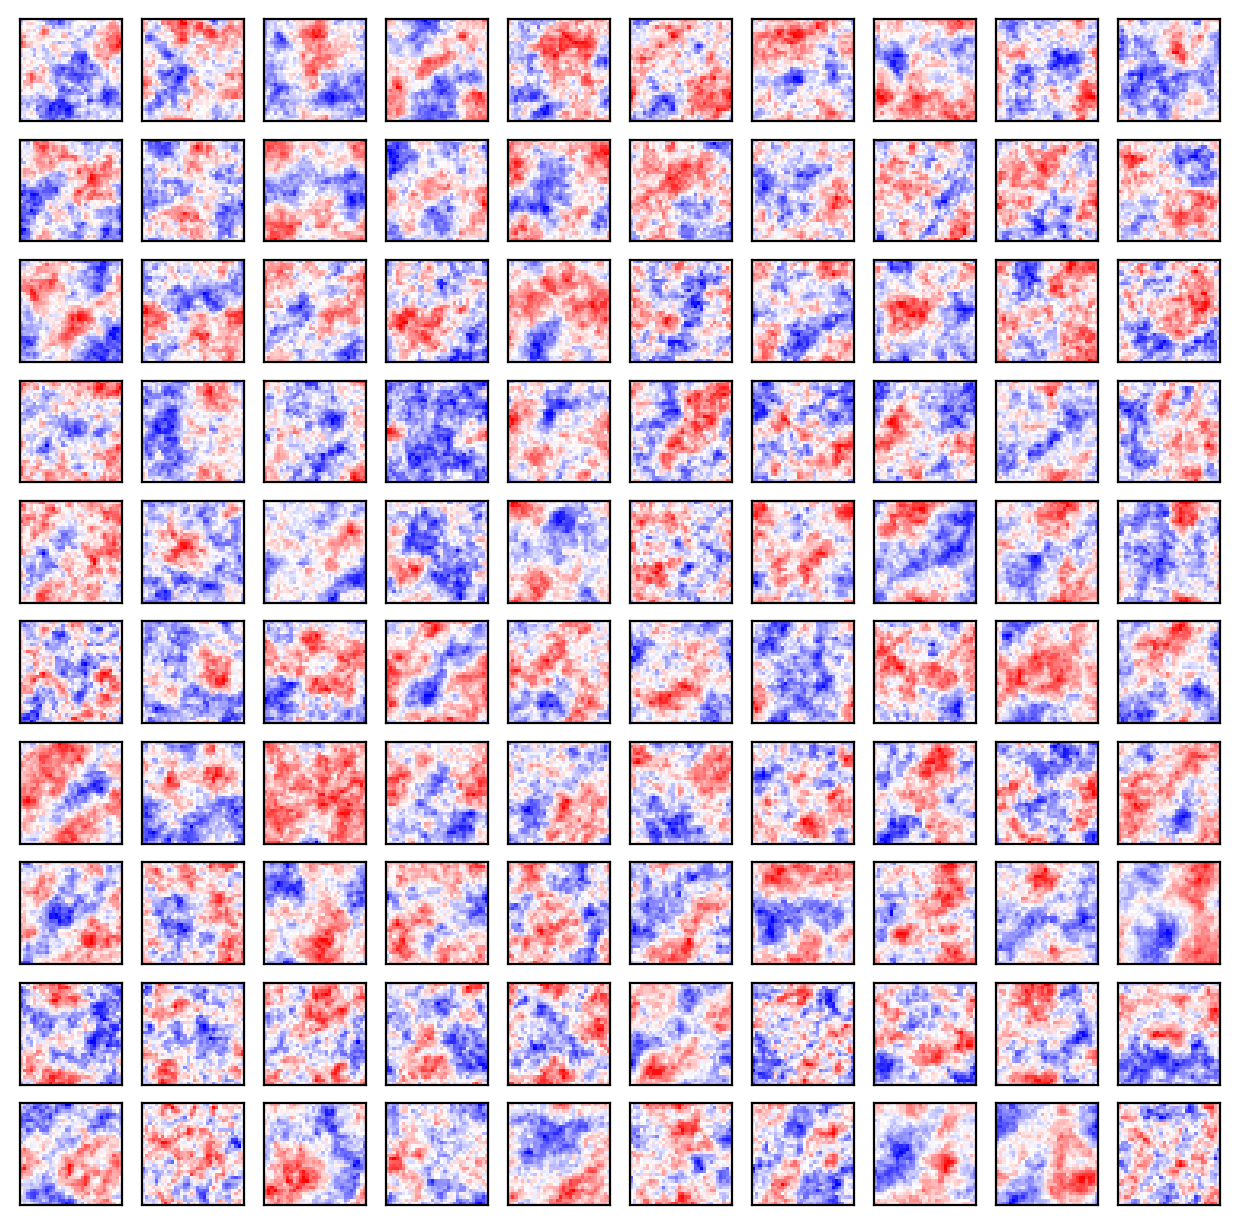

In [9]:
n_draws = 100

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    axd[str(i)].imshow(x, cmap="bwr")

plt.savefig(os.path.join(figs_dir, "grfs.png"))
plt.show()

/scratch-local/slurm-job-tmp-495242/ipykernel_2860/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


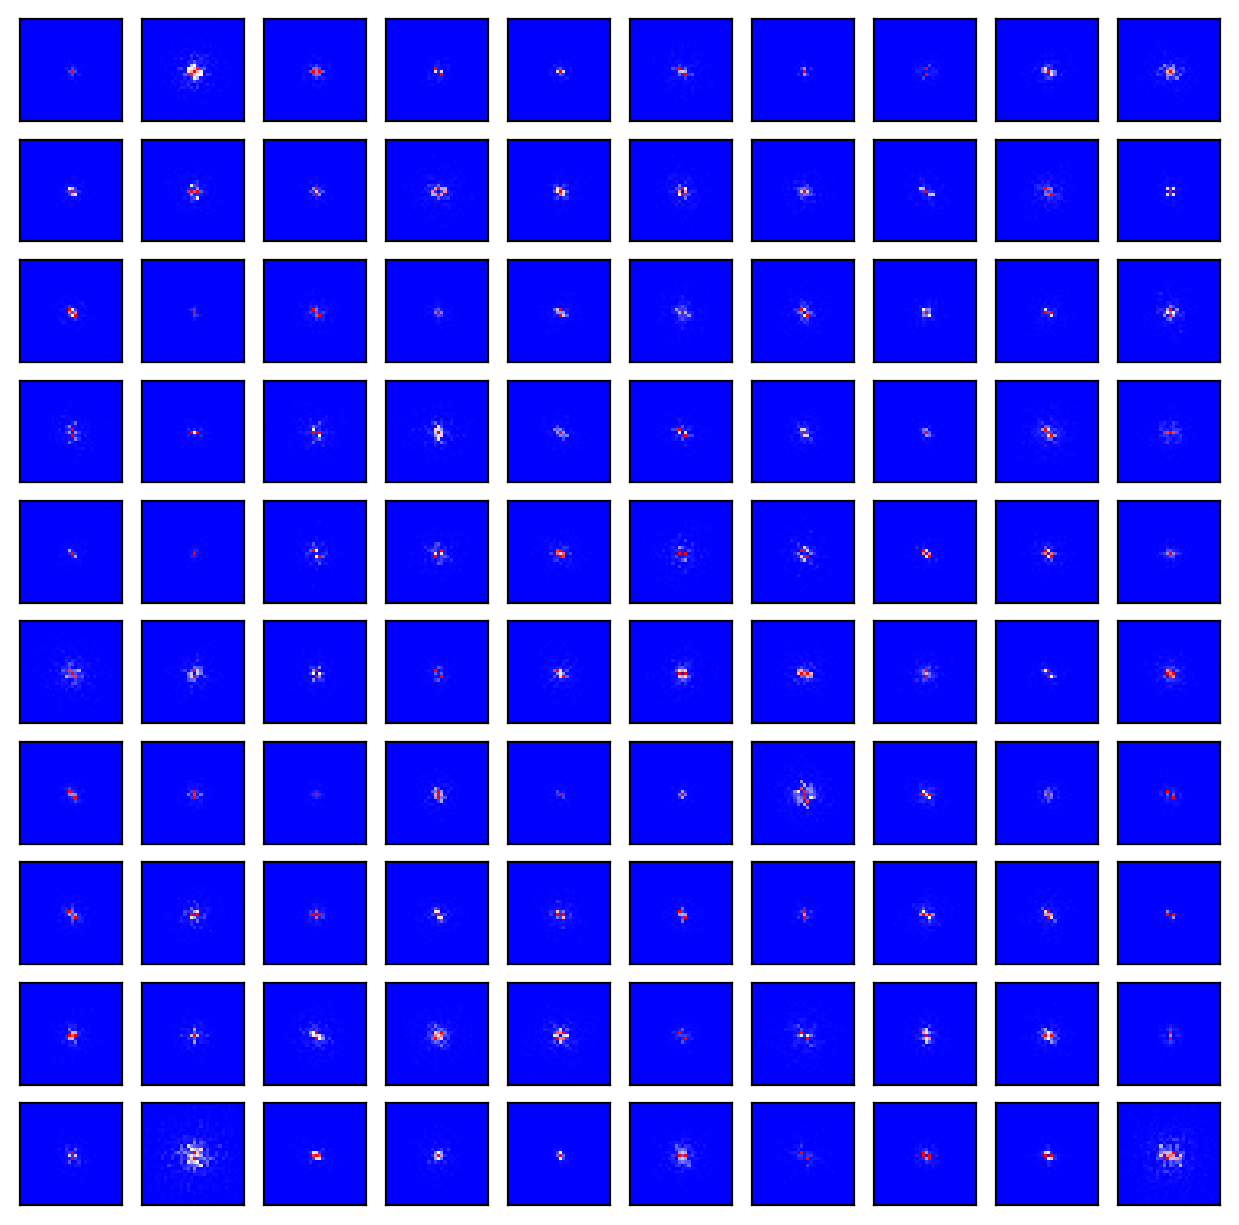

In [10]:
n_draws = 100
box_dims=[1.,1.]
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)



pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    box_dims = [box_dims[0]] * len(x.shape)
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(x.shape)

    ft = fftpack.fftshift(fftpack.fftn(x.astype('float64')))*np.sqrt(pixelsize ** 2. / boxvol)


	# Scale by box volume

    axd[str(i)].imshow(np.abs(ft)**2, cmap="bwr")



plt.savefig(os.path.join(figs_dir, "grfs_power_spectrum.png"))
plt.show()

/scratch-local/slurm-job-tmp-495242/ipykernel_2860/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


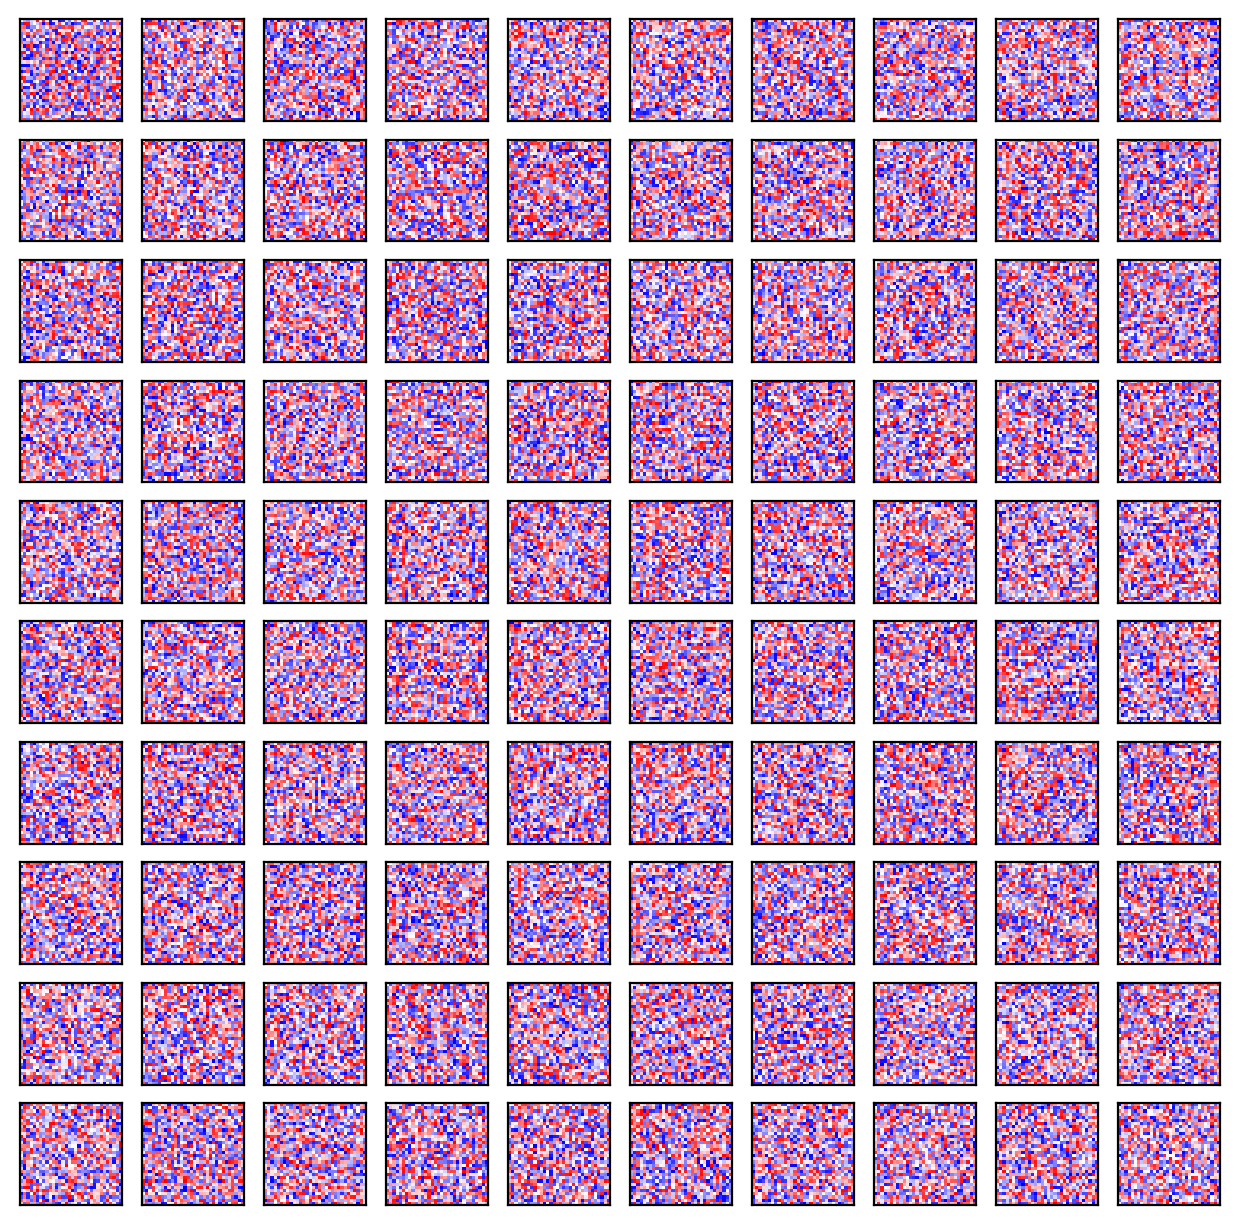

In [11]:
n_draws = 100
box_dims=[1.,1.]
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)



pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    box_dims = [box_dims[0]] * len(x.shape)
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(x.shape)

    ft = fftpack.fftshift(fftpack.fftn(x.astype('float64')))*np.sqrt(pixelsize ** 2. / boxvol)


	# Scale by box volume

    axd[str(i)].imshow(np.angle(ft), cmap="bwr")



plt.savefig(os.path.join(figs_dir, "grfs_spectrum_angle.png"))
plt.show()

/scratch-local/slurm-job-tmp-495242/ipykernel_2860/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


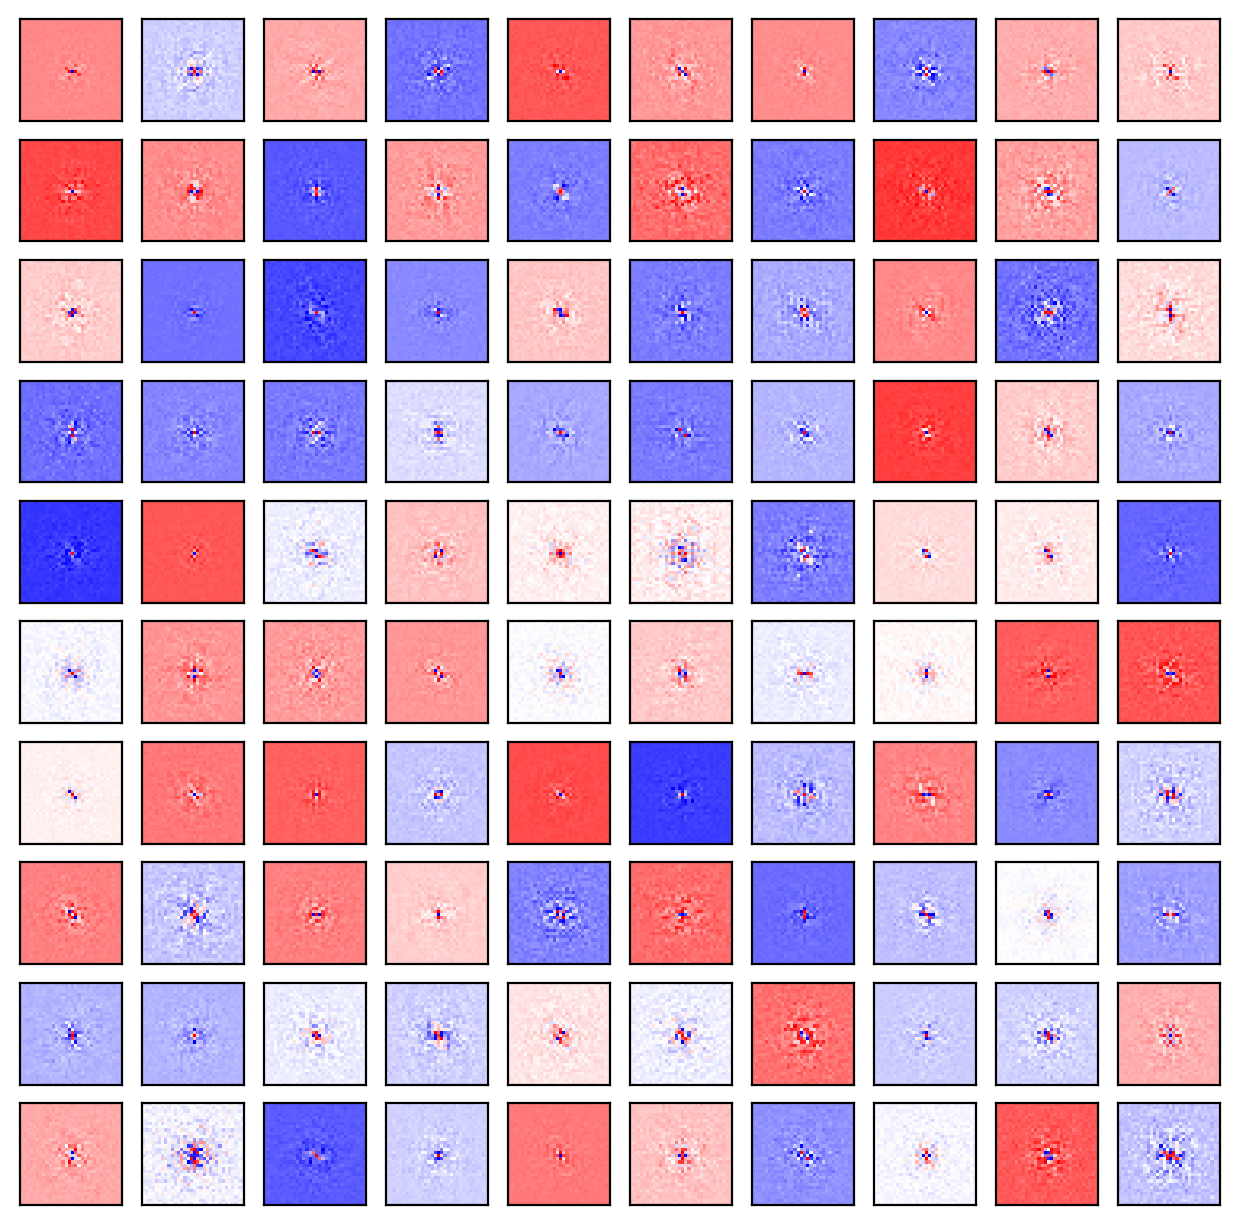

In [13]:
n_draws = 100
box_dims=[1.,1.]
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)



pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    box_dims = [box_dims[0]] * len(x.shape)
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(x.shape)

    ft = fftpack.fftshift(fftpack.fftn(x.astype('float64')))*np.sqrt(pixelsize ** 2. / boxvol)


	# Scale by box volume

    axd[str(i)].imshow(np.real(ft), cmap="bwr")



plt.savefig(os.path.join(figs_dir, "grfs_real_spectrum.png"))
plt.show()

/scratch-local/slurm-job-tmp-495242/ipykernel_2860/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


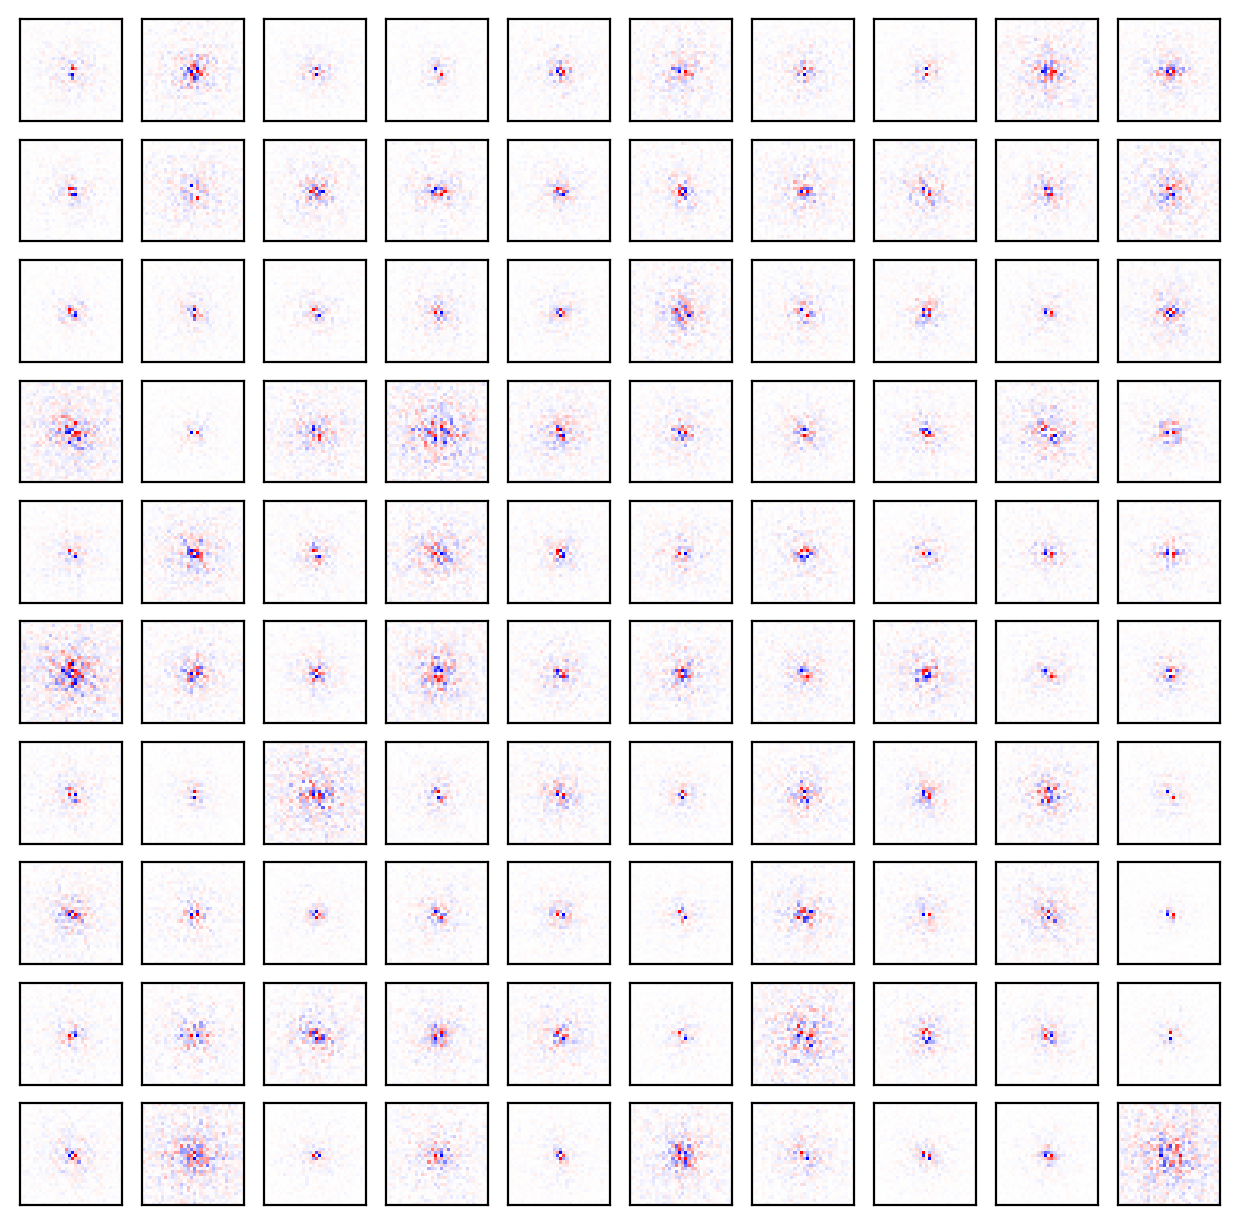

In [14]:
n_draws = 100
box_dims=[1.,1.]
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)



pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
    pks[i] = pk

    box_dims = [box_dims[0]] * len(x.shape)
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(x.shape)

    ft = fftpack.fftshift(fftpack.fftn(x.astype('float64')))*np.sqrt(pixelsize ** 2. / boxvol)


	# Scale by box volume

    axd[str(i)].imshow(np.imag(ft), cmap="bwr")



plt.savefig(os.path.join(figs_dir, "grfs_imag_spectrum.png"))
plt.show()

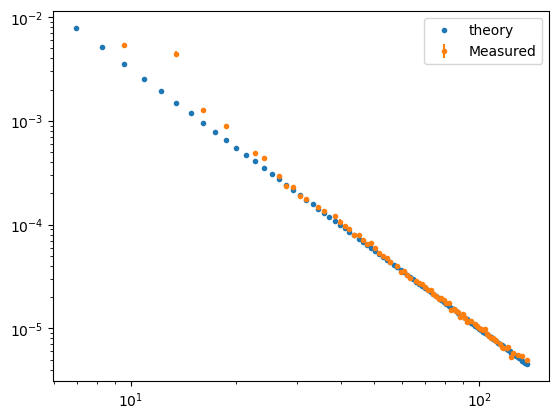

In [8]:
plt.figure()
plt.plot(k, pk_fn(k), marker=".", linestyle="", label="theory")
plt.errorbar(k, pks.mean(axis=0), yerr=pks.std(axis=0) / np.sqrt(n_draws), marker=".", linestyle="", label="Measured")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig(os.path.join(figs_dir, "Pk_fid.png"), bbox_inches="tight")
plt.show()

/scratch-local/slurm-job-tmp-230598/ipykernel_286/2362963103.py:34: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


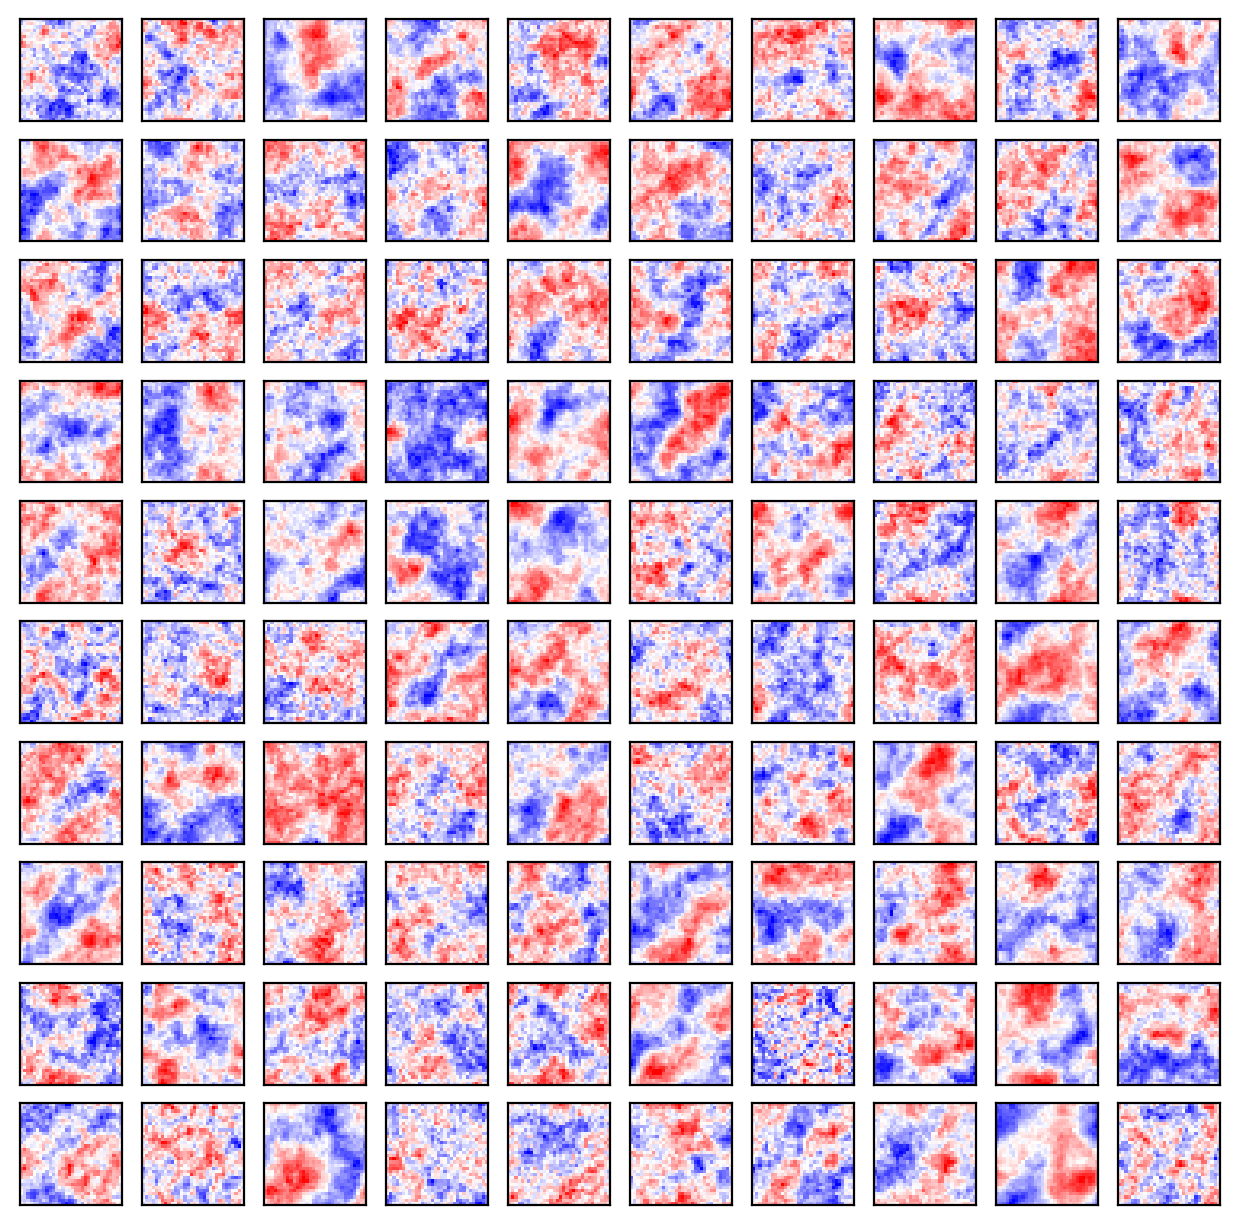

In [9]:
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks_multi_cos = np.zeros((n_draws, 100))
for i in range(n_draws):
    
    A, B = parameters[i]

    # Power spectrum model with sampled parameters
    pk_fn = lambda k: A * k ** -B
    pk_multis=np.zeros((n_draws, 100))
    for j in range(n_draws):
        x = make_gaussian_random_field(
            n_pix,
            box_dim=box_dim,
            power_spectrum=pk_fn,
            random_seed=i
        ) 

        pk, k, modes = power_spectrum_1d(x, box_dim=box_dim, kbins=100)
        pk_multis[j]=pk
    
    pks_multi_cos[i] = pk_multis.mean(axis=0)

    axd[str(i)].imshow(x, cmap="bwr")

plt.savefig(os.path.join(figs_dir, "multi_cosmo_grfs.png"), bbox_inches="tight")
plt.show()

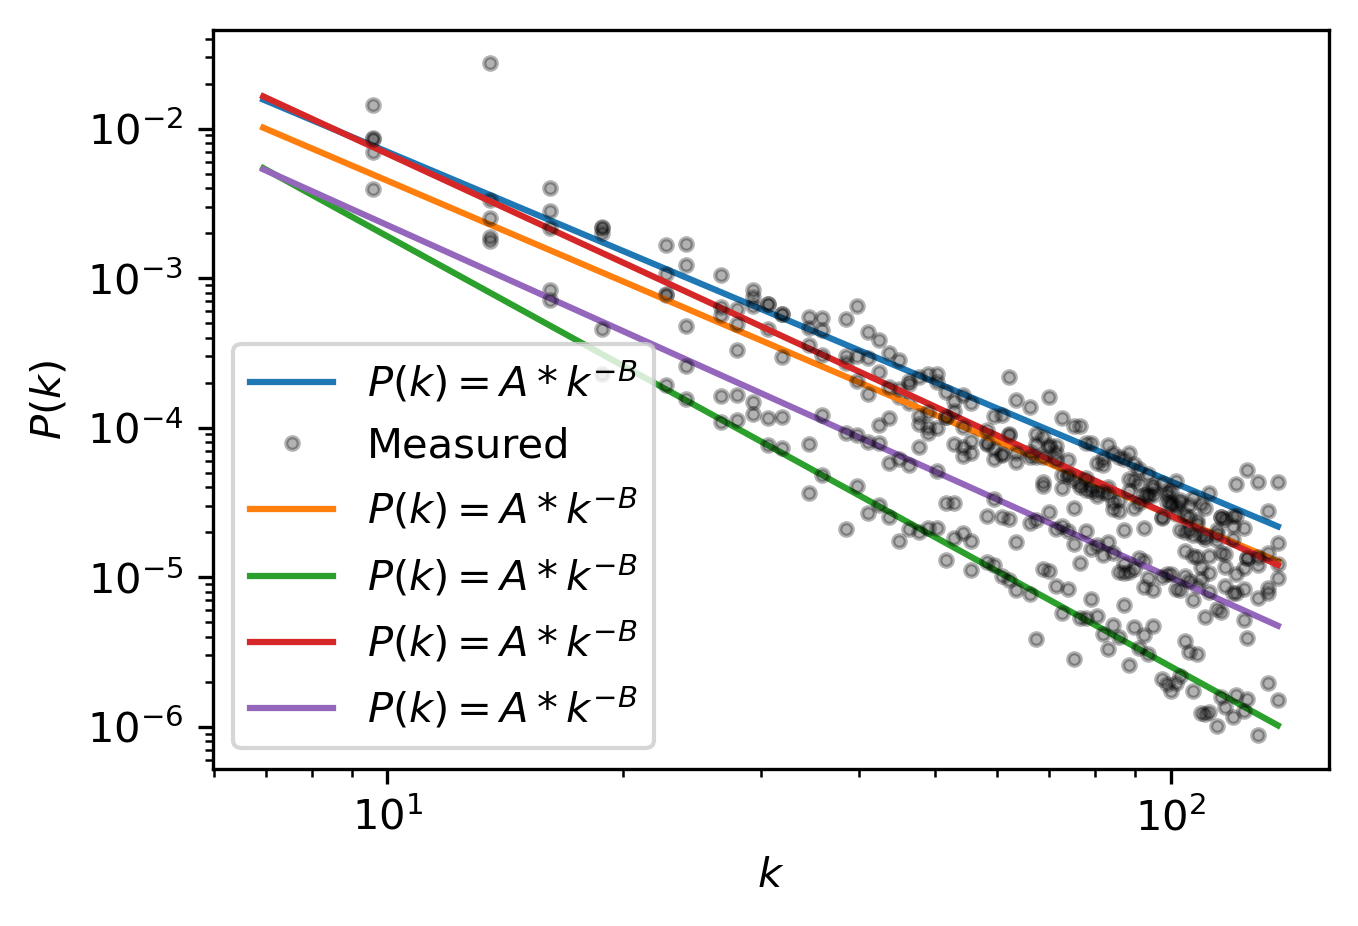

In [10]:
plt.figure(dpi=300, figsize=(4.8, 3.2))

for i in range(5):
    A,B=parameters[i]
    pk_fn=lambda k: A*k**-B
    plt.plot(k, pk_fn(k), label="$P(k)=A * k^{-B}$") 
    plt.plot(
        k, 
        pks_multi_cos[i], 
        marker=".", 
        linestyle="", 
        alpha=0.3,
        color="k", 
        label="Measured" if i == 0 else None
    )
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig(os.path.join(figs_dir, "multi_cosmo_pk.png"), bbox_inches="tight")
plt.show()